In [1]:
import numpy as np
import pandas
import time
import elpigraph
#import elpigraphgpu # If you have a GPU. Requires Cupy
import matplotlib.pyplot as plt
from copy import deepcopy
import rpy2.robjects.packages as rpackages
import rpy2.robjects
import rpy2.robjects.numpy2ri
import rpy2.robjects.pandas2ri
r_elpigraph = rpackages.importr("ElPiGraph.R")
rpy2.robjects.numpy2ri.activate()
rpy2.robjects.pandas2ri.activate()
plt.style.use('seaborn')
np.random.seed(0)

/home/utilisateur/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
10 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  20  nodes on  100  points and  10  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|0|0|0|0|0|0|0|0|1|0||20	0.4224	20	19	3	0	0	0	0.3776	0.3764	0.5419	0.5434	0.041	0.0038	0.0765	1.5297	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
1.5671  seconds elapsed


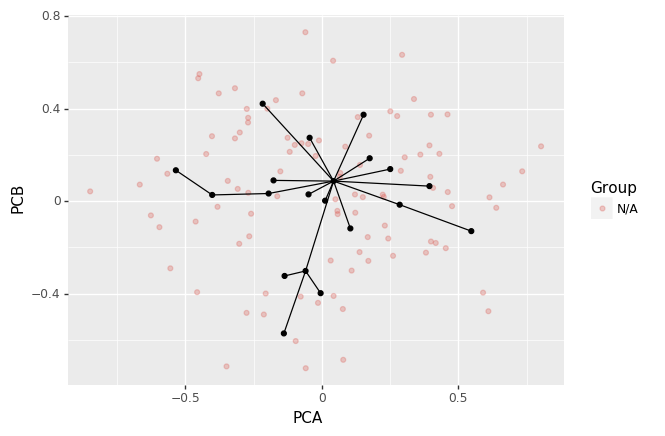

[<ggplot: (8783209036317)>]
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
10 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  20  nodes on  100  points and  10  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||20	0.4966	20	20	20	0	0	0	0.4509	0.4501	0.4352	0.4362	0.0155	0.0302	0.6043	12.0869	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.518  seconds elapsed


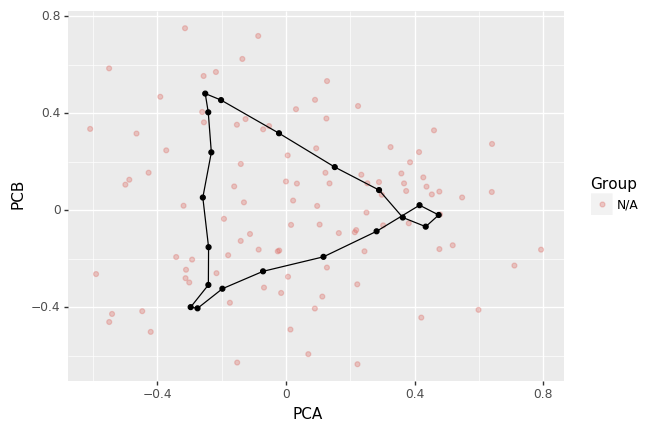

[<ggplot: (8783210637957)>]
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
10 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  20  nodes on  100  points and  10  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 

In [ ]:
elpigraph.computeElasticPrincipalTree(np.random.random((100,10)),20,StoreGraphEvolution=True)
elpigraph.computeElasticPrincipalCircle(np.random.random((100,10)),20,StoreGraphEvolution=True)
elpigraph.computeElasticPrincipalCurve(np.random.random((100,10)),20,StoreGraphEvolution=True)

elpigraph.computeElasticPrincipalTree(np.random.random((100,10)),20,StoreGraphEvolution=False)
elpigraph.computeElasticPrincipalCircle(np.random.random((100,10)),20,StoreGraphEvolution=False)
elpigraph.computeElasticPrincipalCurve(np.random.random((100,10)),20,StoreGraphEvolution=False)

# I - Checking output
### Step 1 :  generate output for R and Python

In [2]:
# Load the example data or real data
data =  np.genfromtxt('data/tree_data.csv', delimiter=',')

# Create desired list of inputs for R and Python
input_data = [data]*5
epg_n_nodes = [20,25,15,20,30]
epg_lambda = [.1,.02,.7,.03,.08]
epg_mu = [.02,.07,.01,.04,.06]
epg_trimmingradius = [float('inf'),.7,.8,.6,.5]
epg_finalenergy = ['Penalized','Base','Penalized','Base','Base']
epg_alpha = [.01,.03,.05,.08,.04]
epg_beta = [.03,.02,.04,.07,.01]
epg_mode = [2,1,1,2,1]
epg_n_processes = [1,2,1,2,1]
epg_collapse_mode = ['PointNumber','PointNumber_Extrema','PointNumber_Leaves','EdgesNumber','EdgesLength']
epg_collapse_par = [5,7,4,6,3]
epg_maxsteps = [float('inf'),1000,100,20,200]
                                  # Python uses WeightedCentroid not Weigthed (corrected typo)
epg_ext_mode =   ['QuantDists','QuantCentroid','WeightedCentroid','QuantCentroid','WeightedCentroid']
r_epg_ext_mode = ['QuantDists','QuantCentroid','WeigthedCentroid','QuantCentroid','WeigthedCentroid'] 
epg_ext_par = [.5,.6,.8,.9,.5]
epg_shift_mode = ['NodeDensity','NodePoints','NodeDensity','NodePoints','NodeDensity']
epg_shift_radius = [0.05,0.07,0.04,0.08,0.03]
epg_shift_max = [5,7,4,8,6]



# Results storage Python
epg_main = []
epg_obj_collapse = []
epg_obj_shift = []
epg_obj_extend = []
epg_obj_fineTune = []
# Results storage R
r_epg_main = []
r_epg_obj_collapse = []
r_epg_obj_shift = []
r_epg_obj_extend = []
r_epg_obj_fineTune = []

for i in range(len(input_data)):
    
    ############################ Run functions, Python version ###################################
    
    epg_main.append(elpigraph.computeElasticPrincipalTree(X=input_data[i],NumNodes = epg_n_nodes[i], 
                                                          Lambda=epg_lambda[i], Mu=epg_mu[i],
                                                          TrimmingRadius = epg_trimmingradius[i],
                                                          FinalEnergy = epg_finalenergy[i],
                                                          alpha = epg_alpha[i],
                                                          beta = epg_beta[i],                                                    
                                                          Do_PCA=False,CenterData=False,
                                                          n_cores = epg_n_processes[i],
                                                          nReps=1,
                                                          EmbPointProb=1.0,
                                                          drawPCAView=False,
                                                          Mode = epg_mode[i],
                                                          MaxSteps = epg_maxsteps[i])[0])
    
    # util functions input
    epg_obj = epg_main[i]
    init_nodes_pos = epg_obj['NodePositions']
    init_edges = epg_obj['Edges'][0]
    #########################################
    try:
        epg_obj_collapse.append(elpigraph.CollapseBranches(X = input_data[i], PG = epg_obj, Mode = epg_collapse_mode[i], ControlPar = epg_collapse_par[i]))
    except:
        epg_obj_collapse.append('bug')

    epg_obj_shift.append(elpigraph.ShiftBranching(X = input_data[i], 
                                                  PG = epg_obj, 
                                                  TrimmingRadius = epg_trimmingradius[i],                       
                                                  SelectionMode = epg_shift_mode[i], 
                                                  DensityRadius = epg_shift_radius[i],
                                                  MaxShift = epg_shift_max[i]))
    
    epg_obj_extend.append(elpigraph.ExtendLeaves(X = input_data[i], 
                                                 PG = epg_obj,
                                                 TrimmingRadius = epg_trimmingradius[i],
                                                 Mode = epg_ext_mode[i], 
                                                 ControlPar = epg_ext_par[i],
                                                 PlotSelected = False,
                                                 DoSA_maxiter=4000)) #number of iterations for simulated annealing
    
    epg_obj_fineTune.append(elpigraph.fineTuneBR(X=input_data[i],
                                                MaxSteps = epg_maxsteps[i],
                                                Mode = 2,
                                                NumNodes = epg_n_nodes[i], 
                                                InitNodePositions = init_nodes_pos,
                                                InitEdges=init_edges,
                                                Lambda=epg_lambda[i], Mu=epg_mu[i],
                                                TrimmingRadius= epg_trimmingradius[i],
                                                FinalEnergy = epg_finalenergy[i],
                                                alpha = epg_alpha[i],
                                                beta = epg_beta[i],                                                    
                                                Do_PCA=False,CenterData=False,
                                                drawAccuracyComplexity = False, drawEnergy = False,drawPCAView = False,
                                                n_cores = epg_n_processes[i],
                                                nReps=1,
                                                ProbPoint=1.0)[0])
    
    ############################ Run functions, R version ###################################

    tmp = r_elpigraph.computeElasticPrincipalTree(X=input_data[i],NumNodes = epg_n_nodes[i], 
                                                  Lambda=epg_lambda[i], Mu=epg_mu[i],
                                                  TrimmingRadius= epg_trimmingradius[i],
                                                  FinalEnergy = epg_finalenergy[i],
                                                  alpha = epg_alpha[i],
                                                  beta = epg_beta[i],                                                    
                                                  Do_PCA=False,CenterData=False,
                                                  n_cores = epg_n_processes[i],
                                                  nReps=1,
                                                  ProbPoint=1.0,
                                                  drawPCAView=False,
                                                  Mode = epg_mode[i],
                                                  MaxSteps = epg_maxsteps[i])[0]
    
    r_epg_main.append(dict(zip(tmp.names, map(list,np.array(tmp))))) # Convert R result to dict format
    
    # util functions input
    r_epg_obj = tmp
    init_nodes_pos = r_epg_obj[0]
    init_edges = r_epg_obj[1][0]
    #########################################
    try:
        r_epg_obj_collapse.append(r_elpigraph.CollapseBrances(X = input_data[i], TargetPG = r_epg_obj, Mode = epg_collapse_mode[i], ControlPar = epg_collapse_par[i]))
    except:
        r_epg_obj_collapse.append('bug')

    r_epg_obj_shift.append(r_elpigraph.ShiftBranching(X = input_data[i], 
                                                      TargetPG = r_epg_obj, 
                                                      TrimmingRadius = epg_trimmingradius[i],                       
                                                      SelectionMode = epg_shift_mode[i], 
                                                      DensityRadius = epg_shift_radius[i],
                                                      MaxShift = epg_shift_max[i]))
    
    tmp_ext = r_elpigraph.ExtendLeaves(X = input_data[i], 
                                       TargetPG = r_epg_obj,
                                       TrimmingRadius = epg_trimmingradius[i],
                                       Mode = r_epg_ext_mode[i], 
                                       ControlPar = epg_ext_par[i],
                                       PlotSelected = False)
    r_epg_obj_extend.append(dict(zip(tmp_ext.names, map(list,np.array(tmp_ext)))))
    
    tmp_fineTune = r_elpigraph.fineTuneBR(X=input_data[i],
                                          MaxSteps = epg_maxsteps[i],
                                          Mode = 2,
                                          NumNodes = epg_n_nodes[i], 
                                          InitNodePositions = init_nodes_pos,
                                          InitEdges=init_edges,
                                          Lambda=epg_lambda[i], Mu=epg_mu[i],
                                          TrimmingRadius= epg_trimmingradius[i],
                                          FinalEnergy = epg_finalenergy[i],
                                          alpha = epg_alpha[i],
                                          beta = epg_beta[i],                                                    
                                          Do_PCA=False,CenterData=False,
                                          drawAccuracyComplexity = False, drawEnergy = False,drawPCAView = False,
                                          n_cores = epg_n_processes[i],
                                          nReps=1,
                                          ProbPoint=1.0)[0]
    r_epg_obj_fineTune.append(dict(zip(tmp_fineTune.names, map(list,np.array(tmp_fineTune)))))

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  20  nodes on  492  points and  3  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||20	0.0841	20	19	14	2	0	0	0.0357	0.0343	0.9337	0.9363	0.0475	0.0008	0.0165	0.3296	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.656  seconds elapsed
Removing the terminal branch with nodes: [14 17]
Moving the branching point at node 0
Moving the branching point at node 14
Performing simulated annealing. This may take a while
Performing simulated annealing. This may take a while
Performing simulated annealing. This may take a while
Performing simulated annealing. This may take a whil

### Step 2 : check final output : computePrincipalTree, ExtendLeaves, fineTuneBR
#### For dict keys in (NodePositions, Edges, FinalReport, ElasticMatrix) -> prints key, iteration index, function if a difference is found in the result dictionary

In [18]:
funcs = ['computeElasticPrincipalTree','ExtendLeaves','fineTuneBR']
j = 0  #funcs index
for res_py,res_R in [(epg_main,r_epg_main),(epg_obj_extend,r_epg_obj_extend),(epg_obj_fineTune,r_epg_obj_fineTune)]: # for func in funcs
    for i in range(len(input_data)): # check each set of output
        one_res_py = res_py[i]
        one_res_R = res_R[i]
        
        for key in one_res_py:
            if key == 'NodePositions':
                try: assert np.allclose(one_res_py[key], one_res_R[key])
                except: print(key,i,funcs[j])

            if key == 'Edges':
                try: assert all(map(lambda x:np.all(x),[one_res_py[key][0]==(one_res_R[key][0]-1), #correcting R indexing that starts at one
                                                        one_res_py[key][1][~np.isnan(one_res_py[key][1])]==one_res_R[key][1][~np.isnan(one_res_R[key][1])],
                                                        one_res_py[key][2][~np.isnan(one_res_py[key][2])]==one_res_R[key][2][~np.isnan(one_res_R[key][2])]]))
                except: print(key,i,funcs[j])

            if key == 'FinalReport':
                try: assert(np.allclose(np.array(list(one_res_py[key].values()))[1:].astype(float), 
                                        np.array(one_res_R[key]).flatten()[1:].astype(float)))
                except: print(key,i, funcs[j])

            if key == 'ElasticMatrix':
                try: assert np.all(one_res_py[key] == one_res_R[key])
                except: print(key,i,funcs[j])
    j+=1

NodePositions 0 ExtendLeaves


In [19]:
### This failure case for ExtendLeaves happens when using the 'QuantDists' option (annealing procedure). We can see the added nodes are still quite close, though
print(epg_obj_extend[0]['NodePositions'][-4:])
print('\n',np.array(r_epg_obj_extend[0]['NodePositions'][-4:]))

[[-1.33051535  0.88428135  0.04640504]
 [ 1.21694202  0.94294511  0.00552173]
 [ 0.13717909  1.18861333  0.00745056]
 [-0.03053231 -0.99463782  0.02592863]]

 [[-1.32606864  0.90010366  0.01065414]
 [ 1.2215765   0.9373269   0.0347547 ]
 [ 0.07501994  1.12699983 -0.00160104]
 [-0.0130761  -0.993484    0.03831469]]


### Step 3 : check CollapseBranches, ShiftBranching

In [20]:
for i in range(len(input_data)):
    
    # CollapseBranches         
    try: 
        r_collapse_dict = dict(zip(r_epg_obj_collapse[i].names,r_epg_obj_collapse[i])) 
        # Edges might be correct but differ in ordering between Python and R version. We double-check that
        test_rows = []
        for row in epg_obj_collapse[i]['Edges']:
            test_rows.append(any([all(row==row_r) for row_r in (r_collapse_dict['Edges']-1)]))
        assert (all(test_rows) and np.allclose(epg_obj_collapse[i]['Nodes'],r_collapse_dict['Nodes']))

    except: 
        #Collapse branches can bug for input parameters, or return empty array. We check one of these cases happened for both versions
        try: 
            for obj in [epg_obj_collapse[i],r_epg_obj_collapse[i]]:
                if type(obj) ==str:
                    assert obj == 'bug'  #check if function bugged
                elif type(obj) ==  dict: 
                    assert np.array(obj['Edges']).size == 0    #or check if array is empty, Python
                elif hasattr(np.array(obj[0]),'size'):
                    assert np.array(obj[0]).size == 0          #or check if array is empty, R
            print('CollapseBranches failed for both versions',i)
        except: print('CollapseBranches', i)
        

    # ShiftBranching
    try: 
        # Edges might be correct but differ in ordering. We double-check that :
        r_shift_dict = dict(zip(r_epg_obj_shift[i].names,r_epg_obj_shift[i]))          
        sort_shift_py = epg_obj_shift[i]['Edges'][:,1].argsort()
        sort_shift_r = (r_shift_dict['Edges']-1)[:,1].argsort()
        assert all([np.all(np.array(epg_obj_shift[i]['Edges'][sort_shift_py])==(r_shift_dict['Edges']-1)[sort_shift_r]),  #correcting R indexing that starts at one
                     np.allclose(epg_obj_shift[i]['NodePositions'],r_shift_dict['NodePositions'])])
    except: print('ShiftBranching',i)

# II - Speed comparison

In [4]:
### Python
np.random.seed(0)
num_points = [1000,10000,100000]
num_nodes = [10,20,30,40,50,60]

run_points = []
for j in num_points:
    run_nodes = []
    for i in num_nodes:
        X=np.random.random(size=(j,10))
        s = time.time()
        res = elpigraph.computeElasticPrincipalTree(X = X,NumNodes = i,drawPCAView=False)
        end = time.time() - s
        run_nodes.append(end)
    run_points.append(run_nodes)

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
10 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  10  nodes on  1000  points and  10  dimensions
Nodes =  2 3 4 5 6 7 8 9 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|0|0|0|0|0|0||10	0.6063	10	9	0	0	0	0	0.5868	0.5821	0.3003	0.306	0.0194	0.0	0.0004	0.0036	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.4939  seconds elapsed
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
10 dimensions are bein

In [ ]:
### Python hybrid
# np.random.seed(0)
# num_points = [1000,10000,100000]
# num_nodes = [10,20,30,40,50,60]

# run_points = []
# for j in num_points:
#     run_nodes = []
#     for i in num_nodes:
#         X=np.random.random(size=(j,10))
#         s = time.time()
#         res = elpigraphgpu.computeElasticPrincipalTree(X = X,NumNodes = i,drawPCAView=False)
#         end = time.time() - s
#         run_nodes.append(end)
#     run_points.append(run_nodes)

In [5]:
### R
np.random.seed(0)
num_points = [1000,10000,100000]
num_nodes = [10,20,30,40,50,60]

run_points_r = []
for j in num_points:
    run_nodes = []
    for i in num_nodes:
        X=np.random.random(size=(j,10))
        s = time.time()
        res= r_elpigraph.computeElasticPrincipalTree(X = X,NumNodes = i)
        end = time.time() - s
        run_nodes.append(end)
    run_points_r.append(run_nodes)

[1] "Generating the initial configuration"
[1] "Creating a chain in the 1st PC with 2 nodes"
[1] "Constructing tree 1 of 1 / Subset 1 of 1"
[1] "Performing PCA on the data"
[1] "Using standard PCA"
[1] "10 dimensions are being used"
[1] "100% of the original variance has been retained"
[1] "The elastic matrix is being used. Edge configuration will be ignored"
[1] "Computing EPG with 10 nodes on 1000 points and 10 dimensions"
[1] "Using a single core"
Nodes = 2 3 4 5 6 7 8 9 
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD
1|0|0|0|0|0|0||10	0.6063	10	9	0	0	0	0	0.5868	0.5821	0.3003	0.306	0.01943	3.598e-05	0.0003598	0.003598	0
1.678 sec elapsed
[[1]]

[1] "Generating the initial configuration"
[1] "Creating a chain in the 1st PC with 2 nodes"
[1] "Constructing tree 1 of 1 / Subset 1 of 1"
[1] "Performing PCA on the data"
[1] "Using standard PCA"
[1] "10 dimensions are being used"
[1] "100% of the original variance has been retained"
[1] "The el

In [6]:
### Plotting
for i in range(len(num_points)):

    #plt.plot(num_nodes,np.array(run_points_colab_hybrid[i])/60,marker='.') # run hybrid version if you have a gpu (or get results from colab)
    plt.plot(num_nodes,np.array(run_points[i])/60,marker='.')
    plt.plot(num_nodes,np.array(run_points_r[i])/60,marker='.')

    plt.xlabel('Number of nodes',fontsize=16)
    plt.ylabel('Time (minutes)',fontsize=16)
    plt.legend(['Python_Hybrid_cpu_gpu','Python_one_cpu','R_one_cpu'],fontsize=13)
    plt.title('Number of points (10 dimensions) : '+str(num_points[i]),fontsize=16)
    plt.show()

NameError: name 'num_points' is not defined